In [1]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
read_folder = './clips/'
# subjects: 4001(E0, EC), 4032(E0, EP), 4191(E0, EP)
psg_id = 'SC400100E0'
hypnogram_id = 'SC400100EC'

channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']
channel = channels[1]

In [3]:
signal_path = os.path.join(read_folder, f'{psg_id}-PSG.edf')
label_path = os.path.join(read_folder, f'{hypnogram_id}-Hypnogram.edf')

In [4]:
# read EDF files
edf_signal = pyedflib.EdfReader(signal_path)
edf_label = pyedflib.EdfReader(label_path)

# read data
annotations = edf_label.readAnnotations()
start = edf_signal.getStartdatetime()
signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
data = []
for ch_idx, sig_name, freq in zip( range(len(signals)), signals, frequencies,):
    sig = edf_signal.readSignal(chn=ch_idx)
    idx = pd.date_range(  start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s") )
    data += [pd.Series(sig, index=idx, name=sig_name)]


In [11]:
# create DataFrames
annotations_df = pd.DataFrame(annotations)
annotations_df = annotations_df.T
annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
signal_df =pd.concat(data[0:2], axis=1)

In [13]:
print(data)

[1989-04-25 00:33:30.000    18.801465
1989-04-25 00:33:30.010    16.738462
1989-04-25 00:33:30.020    15.894505
1989-04-25 00:33:30.030    16.644689
1989-04-25 00:33:30.040    18.989011
                             ...    
1989-04-25 00:52:00.950     0.046886
1989-04-25 00:52:00.960     0.046886
1989-04-25 00:52:00.970     0.046886
1989-04-25 00:52:00.980     0.046886
1989-04-25 00:52:00.990     0.046886
Freq: 10L, Name: EEG Fpz-Cz, Length: 111100, dtype: float64, 1989-04-25 00:33:30.000     6.457875
1989-04-25 00:33:30.010     8.761172
1989-04-25 00:33:30.020     9.145055
1989-04-25 00:33:30.030     9.241026
1989-04-25 00:33:30.040    12.408059
                             ...    
1989-04-25 00:52:00.950    -0.068132
1989-04-25 00:52:00.960    -0.068132
1989-04-25 00:52:00.970    -0.068132
1989-04-25 00:52:00.980    -0.068132
1989-04-25 00:52:00.990    -0.068132
Freq: 10L, Name: EEG Pz-Oz, Length: 111100, dtype: float64, 1989-04-25 00:33:30.000    35.234921
1989-04-25 00:33:30.010    

In [6]:
signal_df['N1'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1'] = signal_df.apply(check_sleep_stage, axis=1)

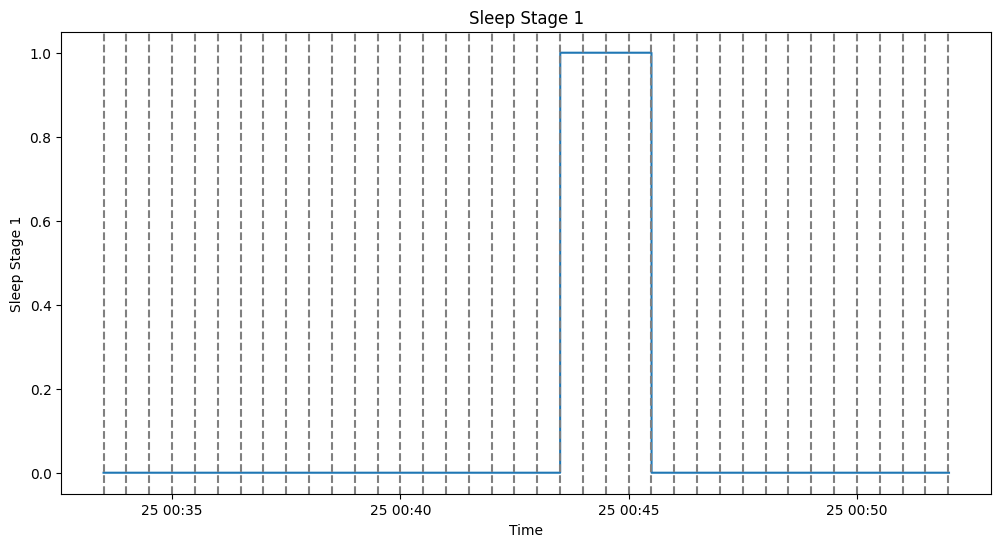

In [7]:
plt.figure(figsize=(12, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()

In [29]:
window_size = 3000 # 30sec * 100Hz = 3000

def calculate_alpha_by_amplitude(rows, freq):
    # Step 1: Fast Fourier Transform (FFT)
    fft_result = np.fft.rfft(rows)
    # Step 2: Calculate alpha wave amplitude in the frequency domain
    return np.mean(np.abs(fft_result[freq]))

signal_df['alpha_amplitude'] = signal_df[channel].rolling(window_size).apply(calculate_alpha_by_amplitude, args=(slice(8,14)))

In [20]:
signal_df

,EEG Fpz-Cz,EEG Pz-Oz,alpha_amplitude
1989-04-25 00:33:30.000,18.801465,6.457875,NaN
1989-04-25 00:33:30.010,16.738462,8.761172,NaN
1989-04-25 00:33:30.020,15.894505,9.145055,NaN
1989-04-25 00:33:30.030,16.644689,9.241026,NaN
1989-04-25 00:33:30.040,18.989011,12.408059,NaN
...,...,...,...
1989-04-25 00:52:00.950,0.046886,-0.068132,3531.152219
1989-04-25 00:52:00.960,0.046886,-0.068132,3531.740223
1989-04-25 00:52:00.970,0.046886,-0.068132,3532.467131
1989-04-25 00:52:00.980,0.046886,-0.068132,3533.409825


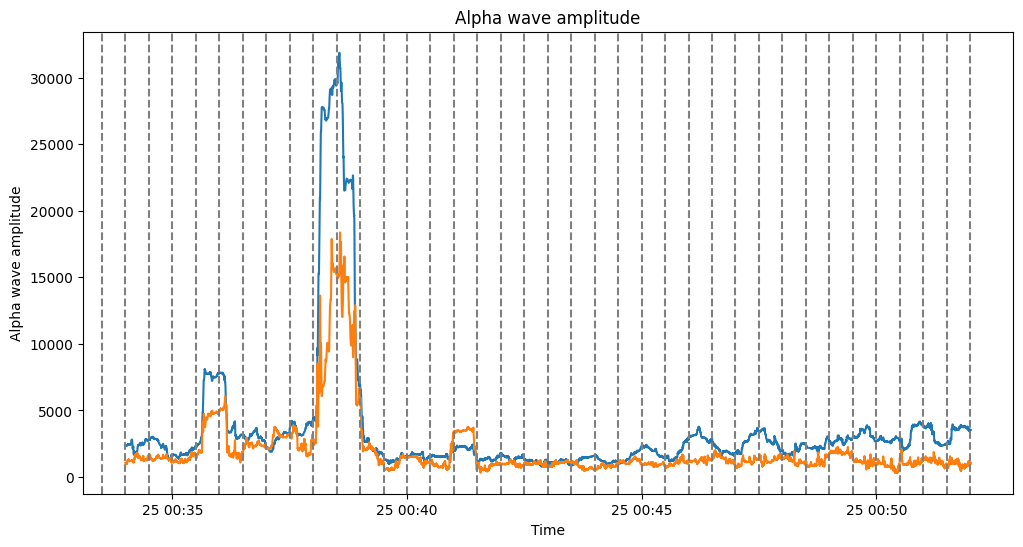

In [26]:
plt.figure(figsize=(12, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['alpha_amplitude'])
plt.plot(signal_df.index, signala)
# 設定圖表標題和標籤
plt.title('Alpha wave amplitude')
plt.xlabel('Time')
plt.ylabel('Alpha wave amplitude')

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')

# 顯示圖表
plt.show()

In [31]:
def calculate_alpha_by_alpha_theta_ratio(rows):
    # Step 1: Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(rows)
    # Step 2: Calculate alpha wave amplitude in the frequency domain
    alpha = np.mean(np.abs(fft_result[8:12]))
    theta = np.mean(np.abs(fft_result[4:6]))
    return alpha / theta

signal_df['alpha_theta_ratio'] = signal_df[channel].rolling(window_size).apply(calculate_alpha_by_alpha_theta_ratio)

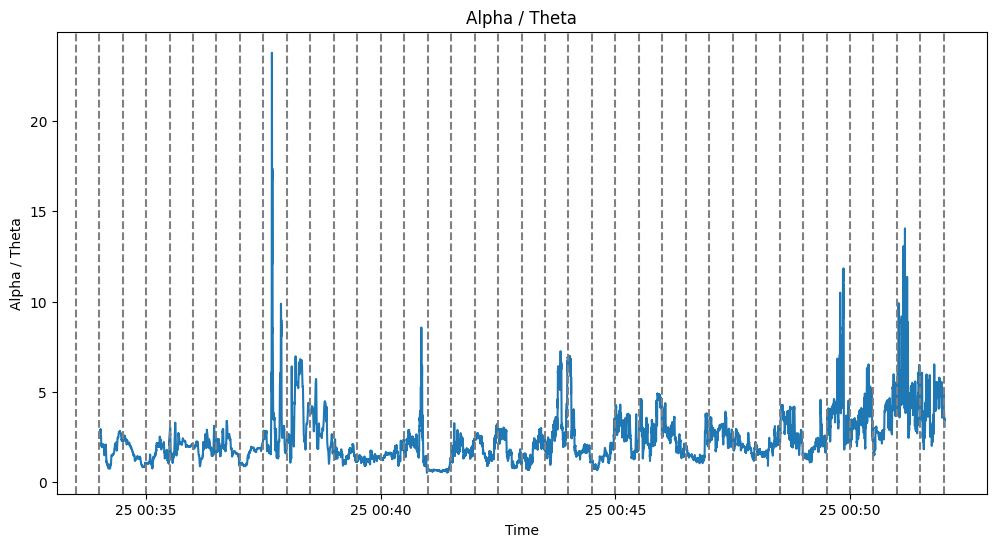

In [32]:
# 設定圖形的寬度和高度
plt.figure(figsize=(12, 6))

# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['alpha_theta_ratio'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')

# 設定圖表標題和標籤
plt.title('Alpha / Theta')
plt.xlabel('Time')
plt.ylabel('Alpha / Theta')

# 顯示圖表
plt.show()


In [13]:
def calculate_alpha_by_amplitude_second(rows):
    alpha_count = 0
    seconds = rows.shape[0] // 100  # 計算秒數，假設每行代表0.01秒
    threshold = 15000

    fft_result_total = np.fft.fft(rows)
    alpha_mean = np.mean(fft_result_total[8:12].real)
    threshold = 350
    for i in range(seconds):
        # Step 1: Fast Fourier Transform (FFT)
        fft_result = np.fft.fft(rows[i*100:(i+1)*100])
        # Step 2: Calculate alpha wave magnitude in the frequency domain
        alpha_magnitude = np.abs(fft_result[8:12]).sum()
        # Step 3: Check if alpha magnitude exceeds the threshold
        #print(alpha_magnitude)
        if alpha_magnitude > threshold:
            alpha_count += 1

    # Step 4: Determine if alpha waves are present based on duration
    return alpha_count

signal_df['alpha_amplitude_second'] = signal_df[channel].rolling(window_size).apply(calculate_alpha_by_amplitude_second)

In [14]:
signal_df

,EEG Fpz-Cz,EEG Pz-Oz,N1,alpha_amplitude,alpha_theta_ratio,alpha_amplitude_second
1989-07-20 01:54:00.000,2.777778,0.982906,0,NaN,NaN,NaN
1989-07-20 01:54:00.010,-10.466667,1.491331,0,NaN,NaN,NaN
1989-07-20 01:54:00.020,-0.155556,1.067643,0,NaN,NaN,NaN
1989-07-20 01:54:00.030,15.222222,1.915018,0,NaN,NaN,NaN
1989-07-20 01:54:00.040,1.444444,3.016606,0,NaN,NaN,NaN
...,...,...,...,...,...,...
1989-07-20 02:08:00.950,-0.066667,-0.033944,0,1618.695553,1.740979,2.0
1989-07-20 02:08:00.960,-0.066667,-0.033944,0,1619.209894,1.742456,2.0
1989-07-20 02:08:00.970,-0.066667,-0.033944,0,1619.570821,1.743570,2.0
1989-07-20 02:08:00.980,-0.066667,-0.033944,0,1619.936797,1.744813,2.0


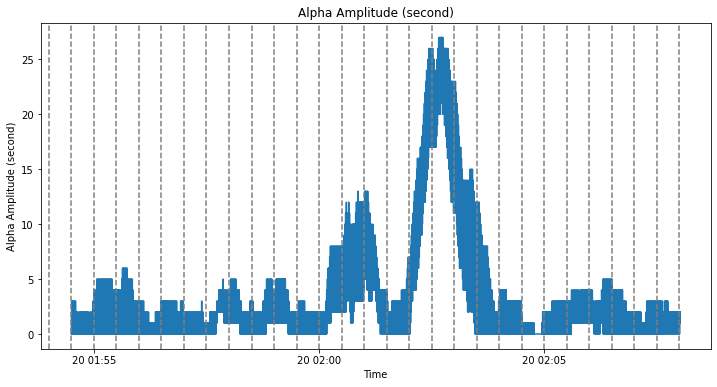

In [15]:
# 設定圖形的寬度和高度
plt.figure(figsize=(12, 6))

# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['alpha_amplitude_second'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')

# 設定圖表標題和標籤
plt.title('Alpha Amplitude (second)')
plt.xlabel('Time')
plt.ylabel('Alpha Amplitude (second)')

# 顯示圖表
plt.show()

In [16]:
import numpy as np

# Step 1: FFT
fft_result = np.fft.fft(signal_df[channel].values)

# Step 2: Define the frequency range for alpha and theta waves
fs = 100  # 取樣率 (假設為每秒100個資料點)
lowcut_alpha = 8  # alpha 波的低頻截止頻率
highcut_alpha = 12  # alpha 波的高頻截止頻率
lowcut_theta = 4  # theta 波的低頻截止頻率
highcut_theta = 8  # theta 波的高頻截止頻率

# Step 3: Apply a frequency domain mask
freq = np.fft.fftfreq(len(signal_df), d=1/fs)  # 取得頻率軸
mask_alpha = np.logical_and(freq >= lowcut_alpha, freq <= highcut_alpha)
mask_theta = np.logical_and(freq >= lowcut_theta, freq <= highcut_theta)
mask = np.logical_or(mask_alpha, mask_theta)
filtered_signal = fft_result * mask_alpha

# Step 4: Inverse FFT (convert back to time domain)
time_domain_signal = np.fft.ifft(filtered_signal)

# Step 5: Write to new column
signal_df['Alpha_wave'] = time_domain_signal.real


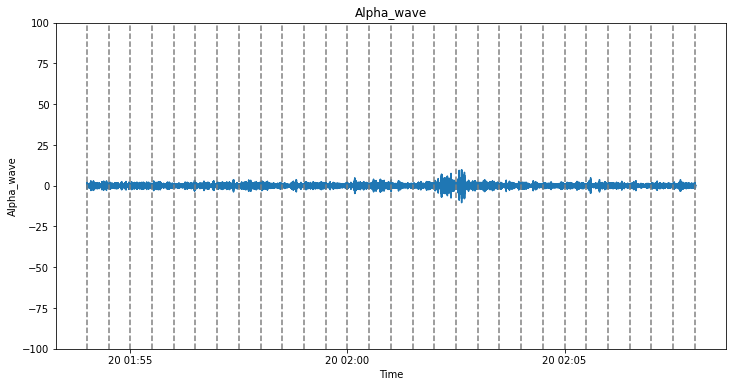

In [17]:
# 設定圖形的寬度和高度
plt.figure(figsize=(12, 6))

# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['Alpha_wave'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')

# 設定圖表標題和標籤
plt.title('Alpha_wave')
plt.xlabel('Time')
plt.ylabel('Alpha_wave')
plt.gca().set_ylim([-100, 100])
# 顯示圖表
plt.show()

In [18]:
signal_df

,EEG Fpz-Cz,EEG Pz-Oz,N1,alpha_amplitude,alpha_theta_ratio,alpha_amplitude_second,Alpha_wave
1989-07-20 01:54:00.000,2.777778,0.982906,0,NaN,NaN,NaN,-0.707582
1989-07-20 01:54:00.010,-10.466667,1.491331,0,NaN,NaN,NaN,-0.261308
1989-07-20 01:54:00.020,-0.155556,1.067643,0,NaN,NaN,NaN,0.296053
1989-07-20 01:54:00.030,15.222222,1.915018,0,NaN,NaN,NaN,0.721137
1989-07-20 01:54:00.040,1.444444,3.016606,0,NaN,NaN,NaN,0.829467
...,...,...,...,...,...,...,...
1989-07-20 02:08:00.950,-0.066667,-0.033944,0,1618.695553,1.740979,2.0,0.568644
1989-07-20 02:08:00.960,-0.066667,-0.033944,0,1619.209894,1.742456,2.0,0.255131
1989-07-20 02:08:00.970,-0.066667,-0.033944,0,1619.570821,1.743570,2.0,-0.219491
1989-07-20 02:08:00.980,-0.066667,-0.033944,0,1619.936797,1.744813,2.0,-0.657024


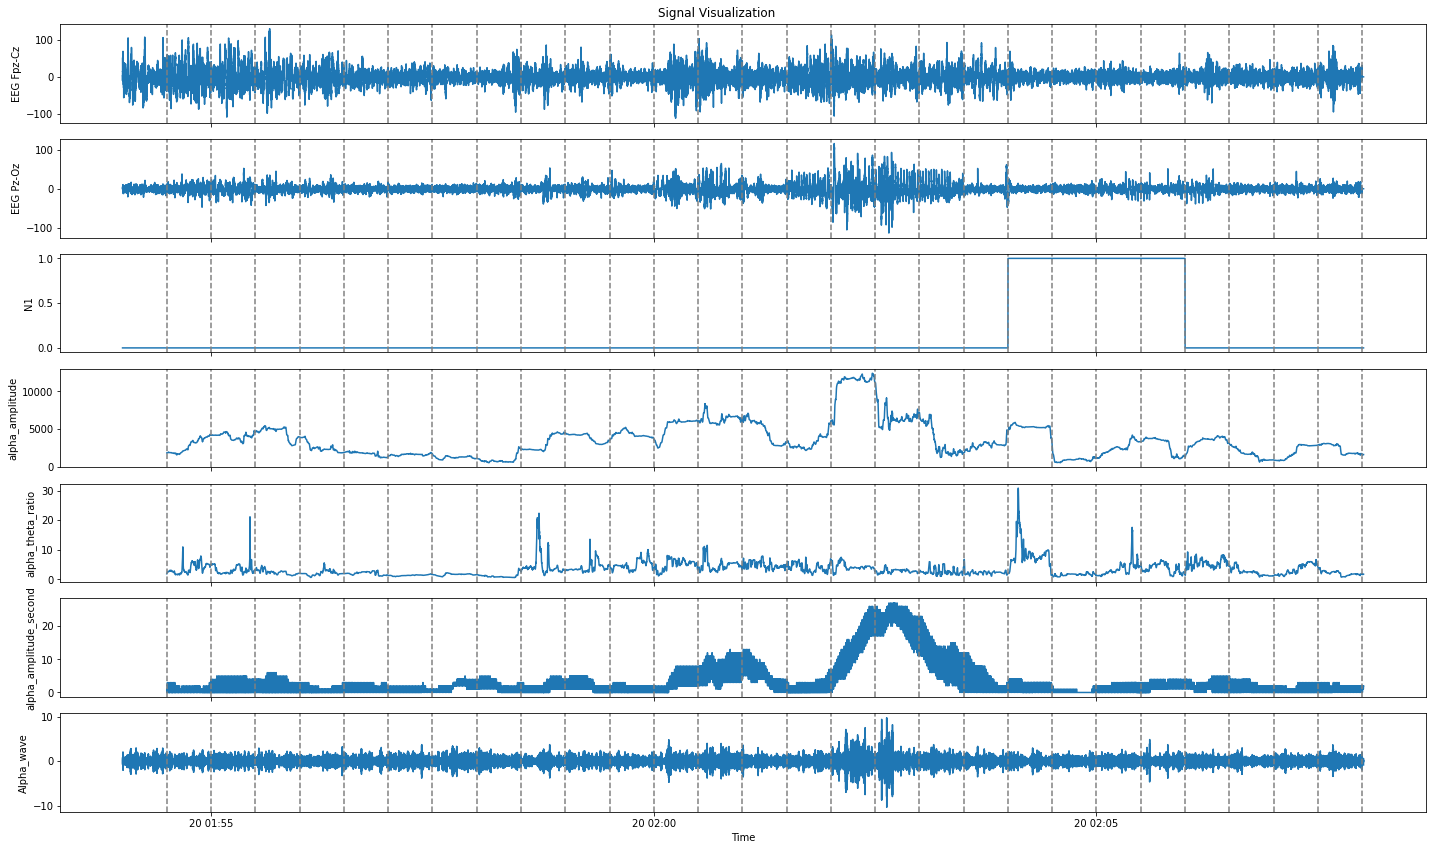

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 取得資料的欄位數量
num_columns = len(signal_df.columns)

# 設定圖表大小
fig, axes = plt.subplots(num_columns, 1, figsize=(20, 12), sharex=True)

# 迴圈遍歷每個欄位
for i, column in enumerate(signal_df.columns):
    # 取得目前的軸
    ax = axes[i]

    # 繪製折線圖
    ax.plot(signal_df.index, signal_df[column])
    
    # 繪製虛線
    start_time = signal_df.index[0]
    end_time = signal_df.index[-1]
    interval = pd.Timedelta(seconds=30)
    current_time = start_time + interval
    while current_time < end_time:
        ax.axvline(x=current_time, linestyle='--', color='gray')
        current_time += interval

    # 設定軸的標籤
    ax.set_ylabel(column)

# 設定圖表標題和共用 x 軸標籤
fig.suptitle('Signal Visualization')
axes[-1].set_xlabel('Time')

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()
